In [ ]:
!pip install community
!pip install tsm
!pip install networkx

In [21]:
!wget "https://curiositybits.cc/files/allaccount_tsm.csv" #在Linux环境下用wget下载原始csv数据

--2021-04-13 18:52:54--  https://curiositybits.cc/files/allaccount_tsm.csv
Resolving curiositybits.cc (curiositybits.cc)... 167.172.139.120, 52.73.87.228
Connecting to curiositybits.cc (curiositybits.cc)|167.172.139.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6728226 (6.4M) [text/csv]
Saving to: ‘allaccount_tsm.csv.1’

allaccount_tsm.csv. 100%[===================>]   6.42M  2.18MB/s    in 2.9s    

2021-04-13 18:52:57 (2.18 MB/s) - ‘allaccount_tsm.csv.1’ saved [6728226/6728226]



In [29]:
import community
import networkx as nx
import tsm
import pandas as pd
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

定义SNA函数

In [23]:
def to_tsm(df):   #to_tsm函数用于清理原始数据并生成包括三栏（from_user_screen_name, content, created_date）的csv表格
    df = df.loc[df['from_user_screen_name'].isnull()==False]
    df = df.loc[df['content'].isnull()==False]
    df_fortsm = df[['from_user_screen_name','content','created_date']]
    df_fortsm = df_fortsm.dropna()
    return df_fortsm

def get_edgelist_fromtsm(csv_filename): #get_edgelist_fromtsm函数用于提炼推特文本中的三层网络关系：retweet, mention, reply， 并生成edgelist
    all_el = tsm.t2e(csv_filename,'ALL', save_prefix=str('all'+csv_filename))
    rt_el = tsm.t2e(csv_filename,'RTS_ONLY',save_prefix=str('rt'+csv_filename))
    mt_el = tsm.t2e(csv_filename,'AT_MENTIONS_ONLY',save_prefix=str('mt'+csv_filename))
    reply_el = tsm.t2e(csv_filename,'REPLIES_ONLY',save_prefix=str('reply'+csv_filename))
    return len(all_el),len(rt_el),len(mt_el),len(reply_el)

def create_networkx(edgelist_file): #create_networkx函数用于讲edgelist转换成networkx对象和GraphML文件
    EDGELIST_matrix = pd.read_csv(edgelist_file, header = 0)
    EG = nx.DiGraph()
    for index, tweet in EDGELIST_matrix.iterrows():
        EG.add_edge(tweet[0],tweet[1])
    print (nx.number_of_edges(EG))
    print (nx.number_of_nodes(EG))
    #EG_igraph = nx.to_pandas_dataframe(EG)
    nx.write_graphml(EG, str(edgelist_file+"graph.graphml"))
    print (str(edgelist_file+"graph.graphml"))
    return EG

def get_network_metrics(gramphml_filename): #get_network_metrics函数用于计算各类SNA指标
    graph = Graph.Read_GraphML(gramphml_filename)
    graph_list = list(graph.vs['id'])
    graph_descriptive = pd.DataFrame(graph_list)
    graph_descriptive.columns = ['node']
    graph_descriptive['indegree'] = graph.vs.degree(type="in")
    graph_descriptive['outdegree'] = graph.vs.degree(type="out")
    graph_descriptive['rawbt'] = graph.betweenness(directed=True)  #could not find normaized bt score in igraph
    graph_descriptive['closeness'] = graph.closeness(normalized=True)
    graph_descriptive['evcent'] = graph.evcent()
    graph_descriptive['hub'] = graph.hub_score()
    graph_descriptive['authority'] = graph.authority_score()
    graph_descriptive['coreness'] = graph.coreness()
    graph_descriptive.to_csv(str("Network_Metrics"+gramphml_filename +'.csv'),sep=',', index = False, header = True)
    return graph_descriptive

将get_edgelist_fromtsm函数应用于原始csv数据。成功操作后会生成三个csv文件：allallaccount_tsm.csv_edgelist.csv, rtallaccount_tsm.csv_edgelist.csv, mtallaccount_tsm.csv_edgelist.csv,replyallaccount_tsm.csv_edgelist.csv

In [14]:
get_edgelist_fromtsm("allaccount_tsm.csv") 

Edge list created.
Data saved to file "allallaccount_tsm.csv_edgelist.csv".
Edge list created.
Data saved to file "rtallaccount_tsm.csv_edgelist.csv".
Edge list created.
Data saved to file "mtallaccount_tsm.csv_edgelist.csv".
Edge list created.
Data saved to file "replyallaccount_tsm.csv_edgelist.csv".


(54510, 18066, 20283, 19630)

将create_networkx应用于基于转发关系的edgelist (即rtallaccount_tsm.csv_edgelist.csv)，该函数可生成一个GraphML文件并属于一个networkx对象（根据下文代码定义，该networkx对象命名为rt）。

In [35]:
rt = create_networkx("rtallaccount_tsm.csv_edgelist.csv")

5602
4271
rtallaccount_tsm.csv_edgelist.csvgraph.graphml


使用networkx库计算四类网络节点指标：入度(indegree)， 出度(outdegree), 中介中心度，接近中心度，特征向量中心度，和HITS算法的权威度（Authority）和枢纽度（Hub）

In [37]:
get_network_metrics("rtallaccount_tsm.csv_edgelist.csvgraph.graphml")

,node,indegree,outdegree,rawbt,closeness,evcent,hub,authority,coreness
0,altright___,2,52,115.25,0.404970,0.211396,0.031844,0.659780,9
1,anthonycumiaxyz,1,0,0.00,0.288260,0.088640,0.000000,0.016416,1
2,amrenaissance,9,0,0.00,0.377742,0.452681,0.000000,0.890983,9
3,rooshv,3,0,0.00,0.359943,0.300036,0.000000,0.676196,3
4,steve_sailer,6,0,0.00,0.373742,0.562904,0.000000,0.813218,6
...,...,...,...,...,...,...,...,...,...
4266,katrinapierson,1,0,0.00,0.306863,0.262868,0.000000,0.061200,1
4267,yspearl,1,0,0.00,0.306863,0.262868,0.000000,0.061200,1
4268,usaassociation,1,0,0.00,0.306863,0.262868,0.000000,0.061200,1
4269,geraldorivera,1,0,0.00,0.306863,0.262868,0.000000,0.061200,1


使用社群发现算法定位聚类

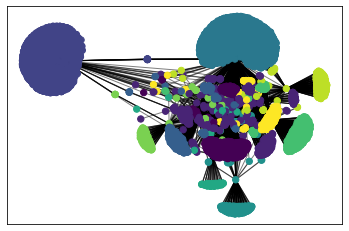

In [36]:
rt = rt.to_undirected(reciprocal=False, as_view=False) #Louvain算法仅适用于undirected graph, 因此首先将网络转化为undirected模式

partition = community_louvain.best_partition(rt) #应用社群发现算法

## 可视化，用不同颜色标注不同社群
pos = nx.spring_layout(rt)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(rt, pos, partition.keys(), node_size=40,cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(rt, pos, alpha=0.5)
plt.show()